Head of the DataFrame:
  observation_date  CPIAUCSL
0       01/01/1947     21.48
1       01/02/1947     21.62
2       01/03/1947     22.00
3       01/04/1947     22.00
4       01/05/1947     21.95

DataFrame with date as index:
                  CPIAUCSL
observation_date          
1947-01-01           21.48
1947-01-02           21.62
1947-01-03           22.00
1947-01-04           22.00
1947-01-05           21.95

Info of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 939 entries, 1947-01-01 to 2025-01-03
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CPIAUCSL  939 non-null    float64
dtypes: float64(1)
memory usage: 14.7 KB
None

DataFrame after data preparation:
                  CPIAUCSL  Daily_Return
observation_date                        
1947-01-01           21.48      0.002888
1947-01-02           21.62      0.006518
1947-01-04           22.00      0.000000
1947-01-05           21.95     -0

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWa


Future Stock Price Forecast:
            Forecasted_Price
2025-01-04         141.39736
2025-01-05         134.48895
2025-01-06         106.28577
2025-01-07          95.67972
2025-01-08          52.50510
2025-01-09          52.54110
2025-01-10          52.54110
2025-01-11          52.54110
2025-01-12          52.54110
2025-01-13          52.54110
2025-01-14          52.54110
2025-01-15          52.54110
2025-01-16          52.54110
2025-01-17          52.54110
2025-01-18          52.54110
2025-01-19          52.54110
2025-01-20          52.54110
2025-01-21          52.54110
2025-01-22          52.54110
2025-01-23          52.54110
2025-01-24          52.54110
2025-01-25          52.54110
2025-01-26          52.54110
2025-01-27          52.54110
2025-01-28          52.54110
2025-01-29          52.54110
2025-01-30          52.54110
2025-01-31          52.54110
2025-02-01          52.54110
2025-02-02          52.54110


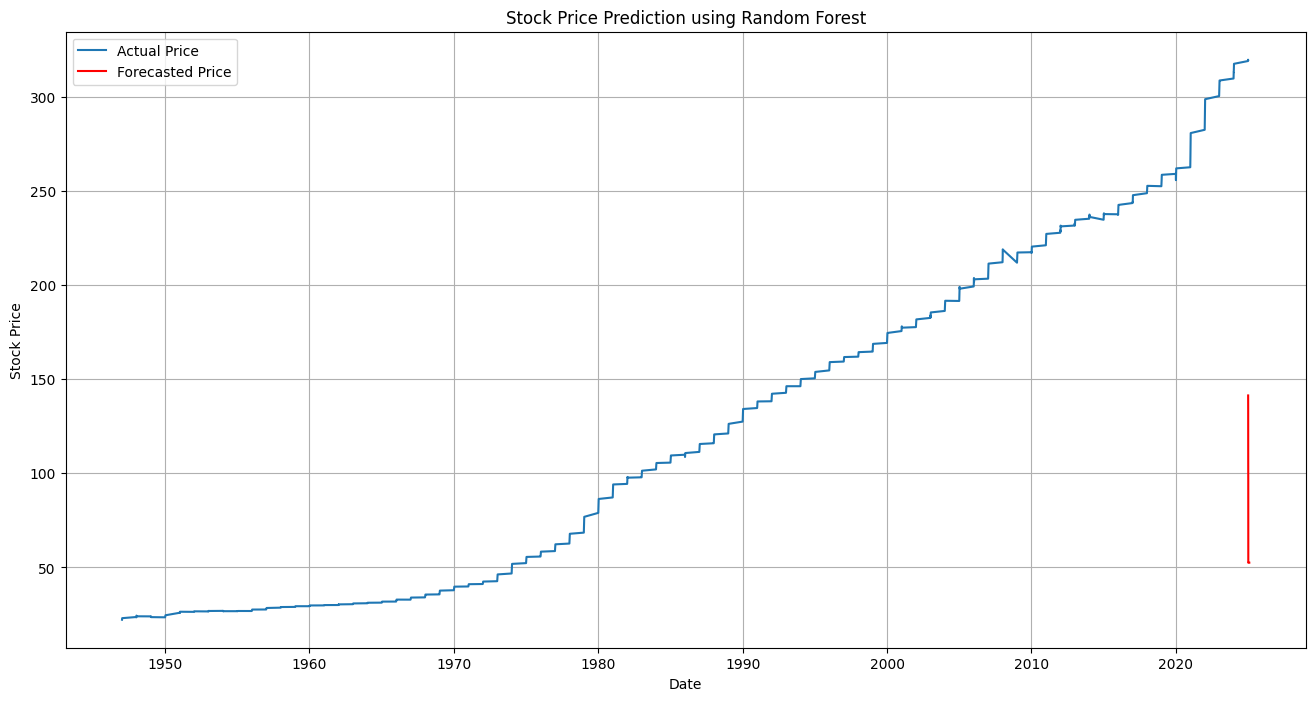

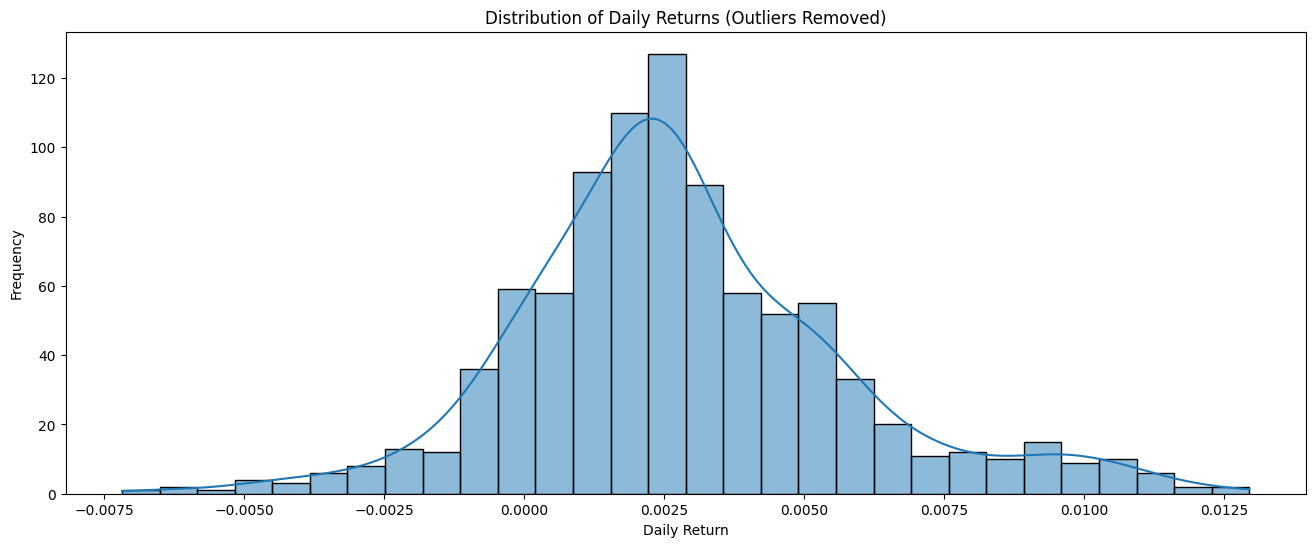

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# --- Configuration ---
file_path = 'C:/Users/USER/Downloads/CPIAUCSL.csv'  # Replace with the actual path to your CSV file
date_column = 'observation_date'  # Replace with your date column name
price_column = 'CPIAUCSL'  # Replace with your stock price column name
n_estimators = 100  # Number of trees in the Random Forest
test_size = 0.2     # Proportion of data for testing
random_state = 42   # For reproducibility
forecast_days = 30  # Number of future days to forecast

# --- Load the dataset ---
try:
    df = pd.read_csv(file_path)
    print("Head of the DataFrame:")
    print(df.head())

    # Convert date column and set as index
    df[date_column] = pd.to_datetime(df[date_column])
    df.set_index(date_column, inplace=True)
    df = df.sort_index()

    print("\nDataFrame with date as index:")
    print(df.head())
    print("\nInfo of the DataFrame:")
    print(df.info())

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except KeyError as e:
    print(f"Error: Column '{e}' not found in the CSV file. Please check the column names.")
    exit()
except ValueError as e:
    print(f"Error: Could not parse date. Please check the date format.")
    exit()

# --- Data Preparation ---
if not df.empty:
    # 1. Calculate Daily Returns
    df['Daily_Return'] = df[price_column].pct_change()

    # 2. Handle Missing Values (filling with the mean or dropping)
    df.fillna(df['Daily_Return'].mean(), inplace=True)  # Fill NaN returns with the mean

    # 3. Handle Outliers (simple Z-score method)
    threshold = 3
    z_scores = np.abs((df['Daily_Return'] - df['Daily_Return'].mean()) / df['Daily_Return'].std())
    df_no_outliers = df[z_scores < threshold].copy()

    print("\nDataFrame after data preparation:")
    print(df_no_outliers.head())

    # --- Feature Engineering (Simple Lagged Features) ---
    lags = 5  # Using the past 5 days' returns as features
    for i in range(1, lags + 1):
        df_no_outliers[f'Return_Lag_{i}'] = df_no_outliers['Daily_Return'].shift(i)
    df_no_outliers.dropna(inplace=True)

    # --- Prepare data for Machine Learning ---
    X = df_no_outliers[[col for col in df_no_outliers.columns if 'Return_Lag' in col]]
    y = df_no_outliers[price_column]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=random_state)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- Fit a Machine Learning Model (Random Forest) ---
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    print(f"\nMean Squared Error on Test Set: {mse:.4f}")

    # --- Forecast Future Stock Prices ---
    last_known_returns = df_no_outliers[['Daily_Return']].tail(lags).values.flatten()
    future_forecasts = []

    for _ in range(forecast_days):
        if len(last_known_returns) < lags:
            # Not enough historical data for prediction
            future_forecasts.append(np.nan)
            break

        # Create a feature vector from the last known returns
        future_features = last_known_returns.reshape(1, -1)
        future_features_scaled = scaler.transform(future_features)

        # Predict the next day's price
        next_price_pred = model.predict(future_features_scaled)[0]
        future_forecasts.append(next_price_pred)

        # Update the last known returns for the next forecast
        last_known_returns = np.roll(last_known_returns, -1)
        last_known_returns[-1] = (next_price_pred / df_no_outliers[price_column].iloc[-1]) - 1 # Simple return

    # Create a date index for the forecast
    last_date = df_no_outliers.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)
    forecast_df = pd.DataFrame({'Forecasted_Price': future_forecasts}, index=future_dates)

    print("\nFuture Stock Price Forecast:")
    print(forecast_df)

    # --- Plotting ---
    plt.figure(figsize=(16, 8))
    plt.plot(df_no_outliers.index, df_no_outliers[price_column], label='Actual Price')
    plt.plot(forecast_df.index, forecast_df['Forecasted_Price'], label='Forecasted Price', color='red')
    plt.title('Stock Price Prediction using Random Forest')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(16, 6))
    sns.histplot(df_no_outliers['Daily_Return'], kde=True)
    plt.title('Distribution of Daily Returns (Outliers Removed)')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.show()

else:
    print("DataFrame is empty, cannot perform financial market forecasting.")